In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import folium
import warnings
import sys
#warnings.filterwarnings('ignore')

print("Geopandas has version {}".format(gpd.__version__))

Geopandas has version 0.13.2


In [2]:
# add paths for modules
sys.path.append('../src/visualization')
print(sys.path)

# import modules
import visualize

['/Users/janhendrikwebert/maritime_route_prediction/notebooks', '/Users/janhendrikwebert/miniforge3/envs/env_geo/lib/python311.zip', '/Users/janhendrikwebert/miniforge3/envs/env_geo/lib/python3.11', '/Users/janhendrikwebert/miniforge3/envs/env_geo/lib/python3.11/lib-dynload', '', '/Users/janhendrikwebert/miniforge3/envs/env_geo/lib/python3.11/site-packages', '../src/visualization']


In [3]:
# read data from file
filename = '../data/raw/AIS_04-09_2022/ais_202204.csv'
df = pd.read_csv(filename, delimiter=';', decimal='.')

In [4]:
# convert to geopandas df
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat), crs="EPSG:4326")
df = []  # free memory

# drop duplicate AIS data (reported by multiple stations)
gdf.drop_duplicates(subset = ['mmsi', 'lat', 'lon'],
                    keep = 'last', inplace=True)

In [5]:
gdf.info()  # print information about loaded data

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 6016737 entries, 0 to 14052975
Data columns (total 12 columns):
 #   Column         Dtype   
---  ------         -----   
 0   mmsi           int64   
 1   imo_nr         int64   
 2   length         int64   
 3   date_time_utc  object  
 4   lon            float64 
 5   lat            float64 
 6   sog            float64 
 7   cog            float64 
 8   true_heading   int64   
 9   nav_status     int64   
 10  message_nr     int64   
 11  geometry       geometry
dtypes: float64(4), geometry(1), int64(6), object(1)
memory usage: 596.8+ MB


In [6]:
gdf.head()

mmsi   imo_nr  length        date_time_utc      lon      lat   sog  \
0  209989000  9235505      90  2022-04-01 06:30:21  4.62360  59.5881  10.0   
1  209989000  9235505      90  2022-04-01 06:30:31  4.62367  59.5877   9.7   
2  209989000  9235505      90  2022-04-01 06:30:40  4.62375  59.5873   9.9   
3  209989000  9235505      90  2022-04-01 06:30:50  4.62384  59.5868   9.8   
4  209989000  9235505      90  2022-04-01 06:31:10  4.62402  59.5859   9.7   

     cog  true_heading  nav_status  message_nr                  geometry  
0  167.2           174           0           1  POINT (4.62360 59.58810)  
1  179.6           174           0           1  POINT (4.62367 59.58770)  
2  173.0           174           0           1  POINT (4.62375 59.58730)  
3  174.7           174           0           1  POINT (4.62384 59.58680)  
4  177.4           174           0           1  POINT (4.62402 59.58590)

658 unique mmsi
646 unique imo_nr
10 unique nav_status
4 unique message_nr


Unique nav_status: 
 [-99, 0, 1, 2, 3, 5, 7, 8, 9, 15]
Unique message_nr: 
 [1, 2, 3, 18]


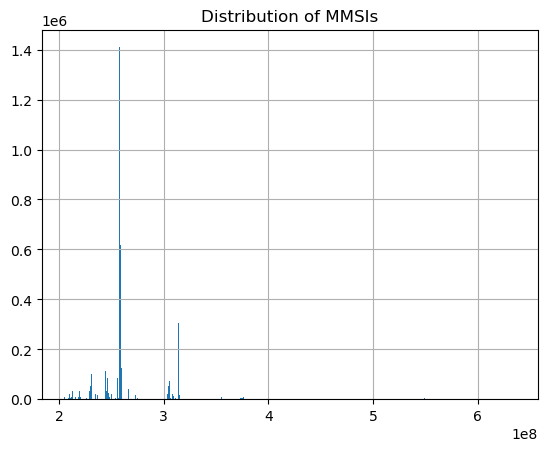

In [7]:
# some dataset characteristics
columns = ['mmsi', 'imo_nr', 'nav_status', 'message_nr']
for column in columns:
    print(f'{gdf[column].nunique()} unique {column}')

# print start and stop labels
print('\n')
print(f'Unique nav_status: \n {sorted(gdf.nav_status.unique())}')
print(f'Unique message_nr: \n {sorted(gdf.message_nr.unique())}')

# plot ditribution of mmsi
plt.subplot(1, 1, 1)
gdf.mmsi.hist(bins=gdf.mmsi.nunique())
plt.title('Distribution of MMSIs')
plt.show()

In [8]:
# plot data (n points)
n_points = 10000  # -1 selects all points
if n_points > 0:
    # selection = np.random.randint(0, high=len(gdf), size=n_points)
    map = gdf.iloc[0:n_points].explore(cmap='jet', column='mmsi', name='AIS messages')
else:
    map = gdf.explore(cmap='jet', column='mmsi', name='AIS messages')

/Users/janhendrikwebert/miniforge3/envs/env_geo/lib/python3.11/site-packages/geopandas/explore.py:400: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif pd.api.types.is_categorical_dtype(gdf[column]):


In [9]:
# get a bounding box of the geographic area
bbox = visualize.get_bounding_box(gdf)
map = bbox.explore(m=map, color='red', name='bounds')
folium.LayerControl().add_to(map)
map

In [11]:
# take a data subset and save to file
n_points = 100000
gdf.iloc[0:n_points].to_file("../data/interim/raw_AIS_apr_2022_Stavanger_100k.geojson", driver='GeoJSON')